In [1]:
pip install mlxtend --upgrade --no-deps

     |████████████████████████████████| 1.3 MB 18.3 MB/s 
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [2]:
import mlxtend                                                        
print(mlxtend.__version__) 

0.19.0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import cv2
import skimage
import keras
import tensorflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from keras.models import Sequential, Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, Dense, Flatten, concatenate, Concatenate#, Dropout
from keras import regularizers
from keras.callbacks import ModelCheckpoint   
from sklearn.metrics import classification_report  
from skimage import color

In [5]:
# fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [ ]:
img_width, img_height = 224, 224
batch_size = 1
epochs = 100                                
train_samples = 7200
validation_samples = 2400
test_samples = 2400

In [ ]:
train_data_dir = 'path to train data'
validation_data_dir = 'path to validation data'
test_data_dir = 'path to test data'

In [ ]:
def scale0to255(image):

    converted_image = image
    min_1 = np.min(converted_image[:,:,0])
    max_1 = np.max(converted_image[:,:,0])
    converted_image[:,:,0] = np.round(((converted_image[:,:,0] - min_1) / (max_1 - min_1)) * 255)
   
    min_2 = np.min(converted_image[:,:,1])
    max_2 = np.max(converted_image[:,:,1])
    converted_image[:,:,1] = np.round(((converted_image[:,:,1] - min_2) / (max_2 - min_2)) * 255)
    
    min_3 = np.min(converted_image[:,:,2])
    max_3 = np.max(converted_image[:,:,2])
    converted_image[:,:,2] = np.round(((converted_image[:,:,2] - min_3) / (max_3 - min_3)) * 255)

    return converted_image 

In [ ]:
def log(image):
  gaus_image = cv2.GaussianBlur(image,(3,3),0)
  laplacian_image = cv2.Laplacian(np.uint8(gaus_image), cv2.CV_64F)
  sharp_image = np.uint8(image + laplacian_image)
  return sharp_image 

In [ ]:
def lch_colorFunction(image):
  log_image = log(image)
  lab_image = skimage.color.rgb2lab(log_image)
  lch_image = skimage.color.lab2lch(lab_image)
  scale_lch_image = scale0to255(lch_image)
  return scale_lch_image  

In [ ]:
def hsv_colorFunction(image):
  log_image = log(image)
  hsv_image  = skimage.color.rgb2hsv(log_image)
  np.nan_to_num(hsv_image, copy=False, nan=0.0, posinf=None, neginf=None)
  scale_hsv_image = scale0to255(hsv_image)
  return scale_hsv_image 

In [ ]:
datagen_rgb = ImageDataGenerator()
datagen_lch = ImageDataGenerator(preprocessing_function = lch_colorFunction)
datagen_hsv = ImageDataGenerator(preprocessing_function = hsv_colorFunction)

In [ ]:
def myGenerator (gen1, gen2, gen3):#
  while True:
    xy1 = gen1.next()
    xy2 = gen2.next()
    xy3 = gen3.next()
    yield ([xy1[0], xy2[0], xy3[0]], xy1[1]) #

In [ ]:
train_generator_rgb = datagen_rgb.flow_from_directory(
                      train_data_dir,
                      color_mode="rgb",
                      target_size=(img_width, img_height),
                      batch_size=batch_size,
                      shuffle=False,
                      class_mode='categorical')

train_generator_lch = datagen_lch.flow_from_directory(
                      train_data_dir,
                      color_mode="rgb",
                      target_size=(img_width, img_height),
                      batch_size=batch_size,
                      shuffle=False,
                      class_mode='categorical')

train_generator_hsv = datagen_hsv.flow_from_directory(
                      train_data_dir,
                      color_mode="rgb",
                      target_size=(img_width, img_height),
                      batch_size=batch_size,
                      shuffle=False,
                      class_mode='categorical')

Found 7200 images belonging to 3 classes.
Found 7200 images belonging to 3 classes.
Found 7200 images belonging to 3 classes.


In [ ]:
train_generator = myGenerator(train_generator_rgb, train_generator_lch, train_generator_hsv)#

In [ ]:
validation_generator_rgb = datagen_rgb.flow_from_directory(
                           validation_data_dir,
                           color_mode="rgb",
                           target_size=(img_width, img_height),
                           batch_size=batch_size,
                           shuffle=False,
                           class_mode='categorical')

validation_generator_lch = datagen_lch.flow_from_directory(
                           validation_data_dir,
                           color_mode="rgb",
                           target_size=(img_width, img_height),
                           batch_size=batch_size,
                           shuffle=False,
                           class_mode='categorical')

validation_generator_hsv = datagen_hsv.flow_from_directory(
                           validation_data_dir,
                           color_mode="rgb",
                           target_size=(img_width, img_height),
                           batch_size=batch_size,
                           shuffle=False,
                           class_mode='categorical')

Found 2400 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.


In [ ]:
validation_generator = myGenerator(validation_generator_rgb, validation_generator_lch, validation_generator_hsv)#

In [ ]:
test_generator_rgb = datagen_rgb.flow_from_directory(
                     test_data_dir,
                     color_mode="rgb",
                     target_size=(img_width, img_height),
                     batch_size= 1,
                     shuffle=False,
                     class_mode='categorical')

test_generator_lch = datagen_lch.flow_from_directory(
                     test_data_dir,
                     color_mode="rgb",
                     target_size=(img_width, img_height),
                     batch_size= 1,
                     shuffle=False,
                     class_mode='categorical')

test_generator_hsv = datagen_hsv.flow_from_directory(
                     test_data_dir,
                     color_mode="rgb",
                     target_size=(img_width, img_height),
                     batch_size= 1,
                     shuffle=False,
                     class_mode='categorical')

Found 2400 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.
Found 2400 images belonging to 3 classes.


In [ ]:
test_generator = myGenerator(test_generator_rgb, test_generator_lch, test_generator_hsv)#

In [6]:
model = load_model('path to mceffnet2_model.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
eff_rgb_0 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
eff_lch_0 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
eff_hsv_0 (InputLayer)          [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
eff_rgb_1 (Rescaling)           (None, 224, 224, 3)  0           eff_rgb_0[0][0]                  
______________________________________________________________________________________________

In [ ]:
inp = model.input
out =model.layers[-1].output
model2 = Model(inp, out)
model2.summary()

In [ ]:
keras.utils.plot_model(model2, "model.png", show_shapes=True)

In [ ]:
train_pred = model2.predict_generator(train_generator,train_samples, verbose=1)
train_pred.shape

In [ ]:
train_target = train_generator_rgb.classes
train_target.shape

In [ ]:
val_pred = model2.predict_generator(validation_generator,validation_samples, verbose=1)
val_pred.shape

In [ ]:
val_target = validation_generator_rgb.classes
val_target.shape

In [ ]:
test_pred = model2.predict_generator(test_generator,test_samples, verbose=1)
test_pred.shape

In [ ]:
test_target = test_generator_rgb.classes
test_target.shape

In [ ]:
X = np.append(train_pred, val_pred, axis=0)
X = np.append(X, test_pred, axis=0)
np.save("path to save mceffnet_features.npy", X)
X.shape

(12000, 3840)

In [ ]:
y = np.append(train_target, val_target, axis=0)
y = np.append(y, test_target, axis=0)
np.save("path to save labels.npy", y)
y.shape

(12000,)

In [6]:
list_fams = ['gan', 'graphics', 'real']
list_fams

['gan', 'graphics', 'real']

In [ ]:
pip install tsne

In [8]:
import numpy as np
from numpy.random import RandomState
np.random.seed(1)

from tsne import bh_sne
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt

import os
import os.path
import glob

from keras.preprocessing import image

In [ ]:
print("Running t-SNE ...")
vis_eff_data = bh_sne(np.float64(X), d=2, perplexity=30., theta=0.5, random_state=RandomState(1))

Running t-SNE ...


In [ ]:
np.save("path to save mceffnet_tsne_features.npy", vis_eff_data)
vis_eff_data.shape

(12000, 2)

In [9]:
vis_eff_data = np.load("path to mceffnet_tsne_features.npy")
y = np.load("path to labels.npy")

Plotting t-SNE ...


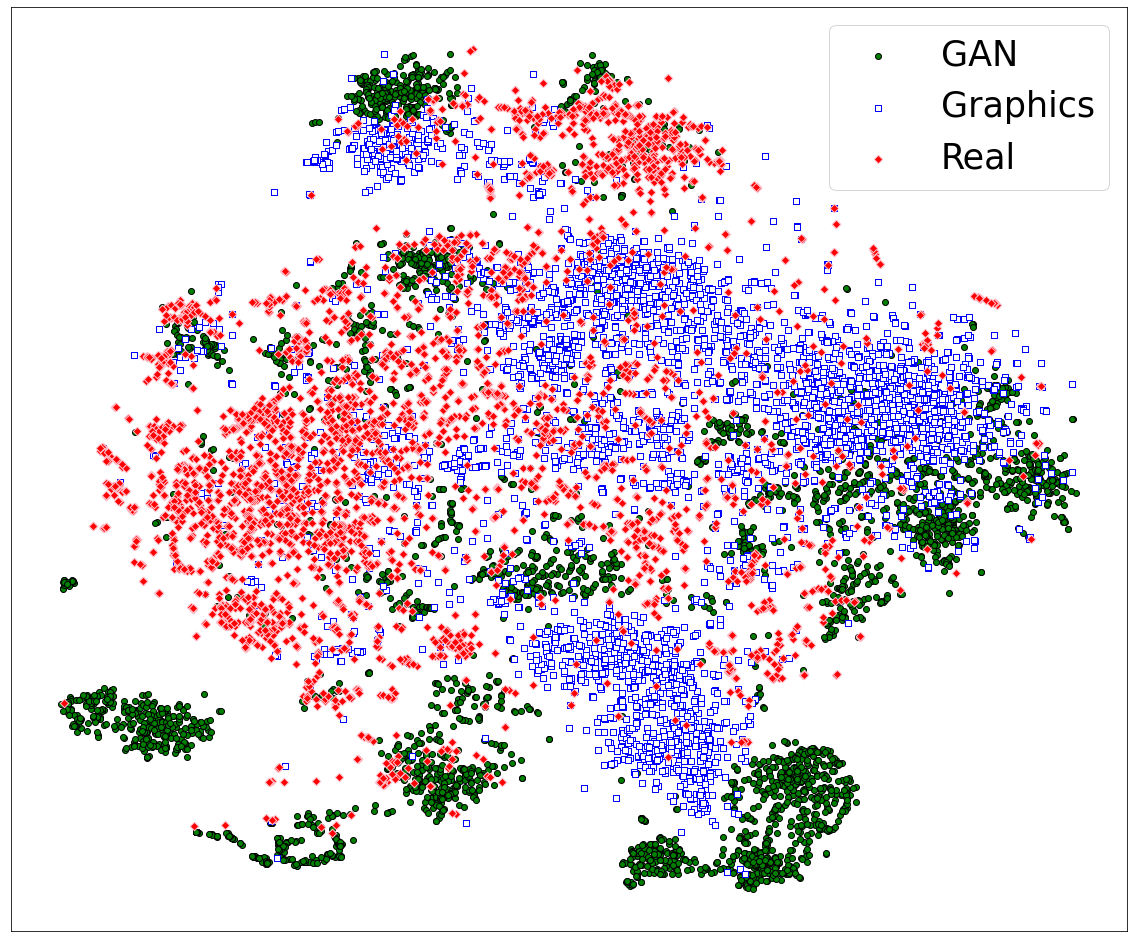

In [24]:
print("Plotting t-SNE ...")
figure = plt.gcf()
figure.set_size_inches(20, 17)
plt.scatter(vis_eff_data[y.astype(int)==0, 0], vis_eff_data[y.astype(int)==0, 1], c='green', marker='o', edgecolors="black", label="GAN")
plt.scatter(vis_eff_data[y.astype(int)==1, 0], vis_eff_data[y.astype(int)==1, 1], c='white', marker='s', edgecolors="blue", label="Graphics")
plt.scatter(vis_eff_data[y.astype(int)==2, 0], vis_eff_data[y.astype(int)==2, 1], c='red', marker='D', edgecolors="pink", label="Real")
plt.clim(-0.5, len(list_fams)-0.5)
frame1 = plt.gca()
frame1.axes.xaxis.set_ticklabels([])
frame1.axes.yaxis.set_ticklabels([])
frame1.axes.get_xaxis().set_visible(False)
frame1.axes.get_yaxis().set_visible(False)
plt.legend(loc="upper right", prop={'size': 35})
#plt.savefig('TSNE_EfficientNet_features_visualization_color_size_20_17.jpg', format='jpg')                  
plt.show()